In [295]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np

import pandas as pd 

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime

# scipy for statistics and optimization
from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

# cvxpy
import cvxpy as cp

# typehints
from typing import Union, List, Tuple

"""
Own packages
"""

from codelib.statistics.moments import corr_to_cov_matrix
from codelib.statistics import moments

from codelib.portfolio_optimization import risk_metrics as rm
from codelib.portfolio_optimization import risk_budget as rb
from codelib.portfolio_optimization import diversification as dm

# exponential probabilites
from codelib.statistics.historical_probabilities import calculate_exponential_decay_probabilities



from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.visualization.base import risk_waterfall_chart, waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Portfolio Heuristics and Risk based Strategies

Last week, we discussed some of the issues with classical Mean-Variance optimization. The main problem is that estimation uncertainty may result in far from optimal portfolios which can lead to bad out-of-sample properties. This notebook discuss some of the pragmatic alternatives based on heuristics such as the naive portfolio ($1 / N$) and the most diversified portfolio. 

## Risk based portfolios 

From last week, we know that an investor with quadratic utility

$$
U(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

the optimal portfolio for the simplest case with no constraint is given by

$$
\mathbf{w}^* = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu} 
$$

The derivative of the optimal portfolio weights wrt. the expected return vector is given by 

$$
\frac{\partial \mathbf{w}^*}{\partial \boldsymbol{\mu}} = \frac{1}{\lambda} \boldsymbol{\Sigma}^{-1}
$$

This illustrates that the optimal portfolio is highly sensitive to the estimated expected returns which have led many academics and practioners to use purely risk based portfolios, relying on e.g. only the covariance matrix. 

### Minimum variance portfolios

As discussed in previous, the minimum variance portfolio is the solution to the below problem. 

$$
\mathbf{w}^* = \underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to relevant constraints, e.g. a budget constraint and a positivity constraints

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0 \; \text{ for } i=1,\dots, N
\end{align}
$$

__Example: Finding the minimum-variance portfolio using `CVXPY`__

In [296]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)

# number of assets
num_assets = len(mu)

In [297]:
"""
Solve for the minimum-variance weights 
"""
# optimization variable
w = cp.Variable(num_assets)

# define constraints 
constraints = [cp.sum(w)==1.0, w>=0]

# define problem 
prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

# solve problem 
prob.solve()

# print weights 
df_port_w = pd.DataFrame(data=w.value, index=['Asset 1', 'Asset 2', 'Asset 3'], columns=['$w_{min-var}$'], )
df_port_w

,$w_{min-var}$
Asset 1,4.782386e-22
Asset 2,1.951220e-01
Asset 3,8.048780e-01


### Risk budgetting portfolios 

We know that we can write the portfolio standard deviation as 

$$
\sigma_p(\mathbf{w}) = \mathbf{w}^\top \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = \sum_{i=1}^N w_i \text{MR}_i = \sum_{i=1}^N \text{RC}_i
$$

where $\text{MR}_i = \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}$ is the marginal risk of asset $i$ and $\text{RC}_i$ is the risk contribution of asset $i$. 

There is a large literature on *risk parity investing* where the focus is on allocating risk instead of capital, e.g. we want an equal amount of risk coming from bonds and stocks. The problem that we want to solve is 

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} = b_i  \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

where $b_i$ is the risk coming from the $i$'th asset. In addition, we would likely impose positivity contraints $b_i \geq 0, w_i \geq 0$, weights summing to one $\sum_{i=1}^N w_i = 1$, and $\sum_{i=1}^N b_i = 1$. 

We have previously seen how we can solve this problem in the two asset case - now we will look at the more general case! 

### Solving for the risk budgetting weights 

Since we know that 

$$
w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = b_i 
$$

We could find the risk budgetting portfolio as 

$$
\mathbf{w}^* = \arg \min \sum_{i=1}^N \left(w_i \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} - b_i \right)^2
$$

subject to

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
w_i &\geq 0 \; \text{ for } i=1,\dots, N
\end{align}
$$

__Example: Find the risk budget portfolio__

We continue with the same assumptions as in the previous example. We seek to find the equal risk contribution weights. 

In [298]:
def risk_budget_objective(weights: np.ndarray, cov_mat: np.ndarray, b: Union[float, np.ndarray] = None): 
    
    if b is None: 
        b = 1.0 / len(weights)
    
    rc = rb.calculate_risk_contributions_std(weights, cov_mat, scale=True)
    
    return np.sum(np.square(rc - b)) * 100 * 100

In [299]:
init_w  = np.ones(num_assets) / num_assets

budget_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}

res_rb = optimize.minimize(risk_budget_objective, x0=init_w, args=(cov_mat,),
                           constraints=(budget_constraint),
                           bounds=[(0.0, 1.0)] * num_assets)

df_port_w['$w_{rb}$'] = res_rb.x

In [300]:
df_port_w

,$w_{min-var}$,$w_{rb}$
Asset 1,4.782386e-22,0.202225
Asset 2,1.951220e-01,0.307039
Asset 3,8.048780e-01,0.490736


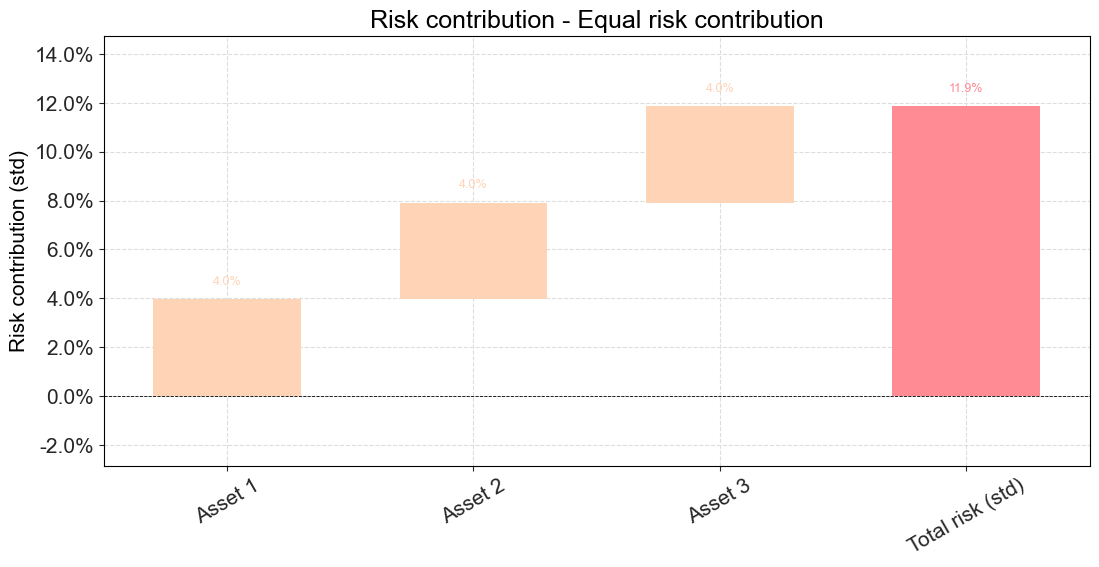

In [301]:
risk_contrib = rb.calculate_risk_contributions_std(df_port_w['$w_{rb}$'], cov_mat)

fig, ax = waterfall_chart(values=risk_contrib*100,
                          labels=df_port_w.index,
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution (std)", title="Risk contribution - Equal risk contribution")

fig.set_size_inches(12, 6);

### Risk budgetting portfolios as a convex optimization problem

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778) suggest an alternative optimization problem that also gives the risk budgetting portfolio

$$
\mathbf{x}^* = \arg \min \mathbf{x}^\top \boldsymbol{\Sigma} \mathbf{x}
$$

subjet to 

$$
\begin{align}
\mathbf{b}^\top \ln \mathbf{x} &\geq c \\
\mathbf{x} &\geq \mathbf{0}
\end{align}
$$

Finally, define 

$$
\mathbf{w}^* = \frac{\mathbf{x}^*}{\mathbf{1}^\top \mathbf{x}^*}
$$

such that the portfolio weights sum to one. 

In [302]:
w = cp.Variable(num_assets)

b = 1.0 / num_assets
c = 0.1

constraints = [w >= 0.0001,
               cp.sum(b * cp.log(w)) >= c]

prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(w, cov_mat)), constraints=constraints)

prob.solve()

w.value / w.value.sum()

array([0.20222576, 0.30703768, 0.49073656])

### Naive Risk Parity

In the naive risk parity portfolio the allocation to a specific asset is based on the inverse volatility portfolio

$$
\mathbf{w}_{\text{IV}} = \left[\frac{1 / \sigma_1}{\sum_{i=1}^N 1 / \sigma_i}, ..., \frac{1 / \sigma_N}{\sum_{i=1}^N 1 / \sigma_i} \right]^\top
$$

In [303]:
def calculate_naive_risk_parity(vols: np.ndarray) -> np.ndarray:
    
    """
    Calculate the inverse volatility weights 
    
    Parameters
    ----------
    vols: 
        Volatilites. 
    
    Returns
    -------
    np.ndarray
        Portfolio weights. 
    
    
    """
    
    inv_vols = 1.0 / vols
    sum_inv_vols = np.sum(inv_vols)
    
    w_iv = inv_vols / sum_inv_vols
    
    return w_iv

In [304]:
df_port_w['$w_{inv-vol}$'] = calculate_naive_risk_parity(vols)

In [305]:
df_port_w

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$
Asset 1,4.782386e-22,0.202225,0.230769
Asset 2,1.951220e-01,0.307039,0.307692
Asset 3,8.048780e-01,0.490736,0.461538


### A simulation study comparing the risk-based strategies





In [306]:
"""
Define functions to calculate optimal portfolios
"""
    
    
def calculate_risk_parity(cov_mat: np.ndarray) -> np.ndarray:  
    
    num_assets = cov_mat.shape[0]
    
    w = cp.Variable(num_assets)

    b = 1.0 / num_assets
    c = 0.1

    constraints = [w >= 0.0001,
                   cp.sum(b * cp.log(w)) >= c]

    prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(w, cov_mat)), constraints=constraints)

    prob.solve()

    return w.value / w.value.sum()
    
    
def calculate_minimum_variance(cov_mat: np.ndarray) -> np.ndarray: 
    
    num_assets = cov_mat.shape[0]
    
    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints 
    constraints = [cp.sum(w)==1.0, w>=0]

    # define problem 
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    # solve problem 
    try:  
        prob.solve()
    except: 
        prob.solve(solver="SCS")
    
    return w.value

In [307]:
"""
Generate data 
"""

T = 60

corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / np.sqrt(12) / 100.0
mu = np.array([3.2, 3.12, 8.0, 8.2]) / 100.0
#mu_2 = np.array([3.2, 3.22, 8.4, 8.2]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat, vols)

num_sim = 10000

sim_cov_mat = stats.wishart.rvs(df = T-1, scale = cov_mat / T, size=num_sim) 
#sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

In [308]:
"""
Find optimal portfolios 
"""

rp_ports = np.array([calculate_risk_parity(sim_cov_mat[i]) for i in range(num_sim)])
naive_rp_ports = np.array([calculate_naive_risk_parity(np.diag(sim_cov_mat[i])) for i in range(num_sim)])
min_var_ports = np.array([calculate_minimum_variance(sim_cov_mat[i]) for i in range(num_sim)])

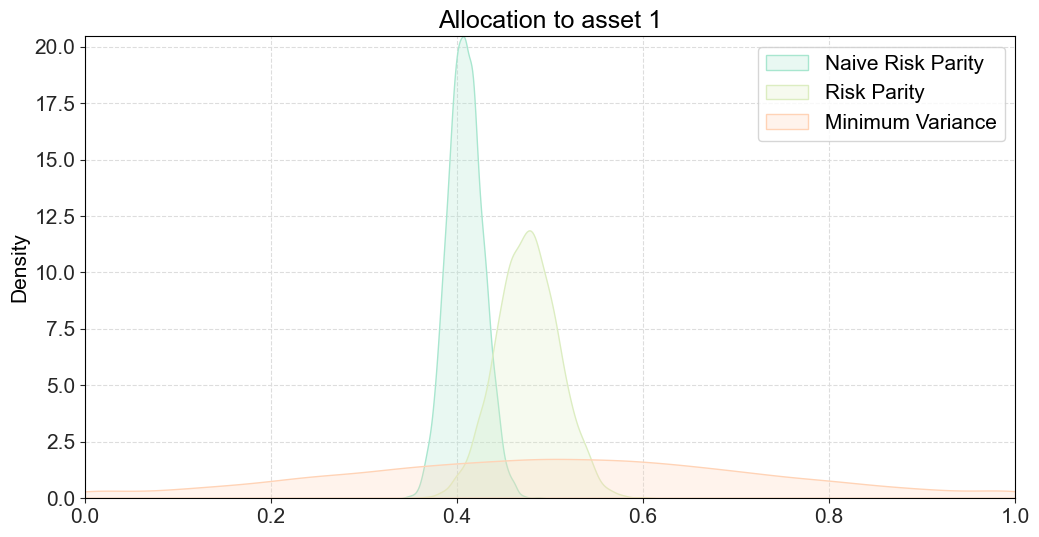

In [309]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_ports[:, 0], fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_ports[:, 0], fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_ports[:, 0], fill=True, ax=ax, label="Minimum Variance")
ax.set_xlim([0.0, 1.0])
ax.set_title("Allocation to asset 1")
ax.legend();

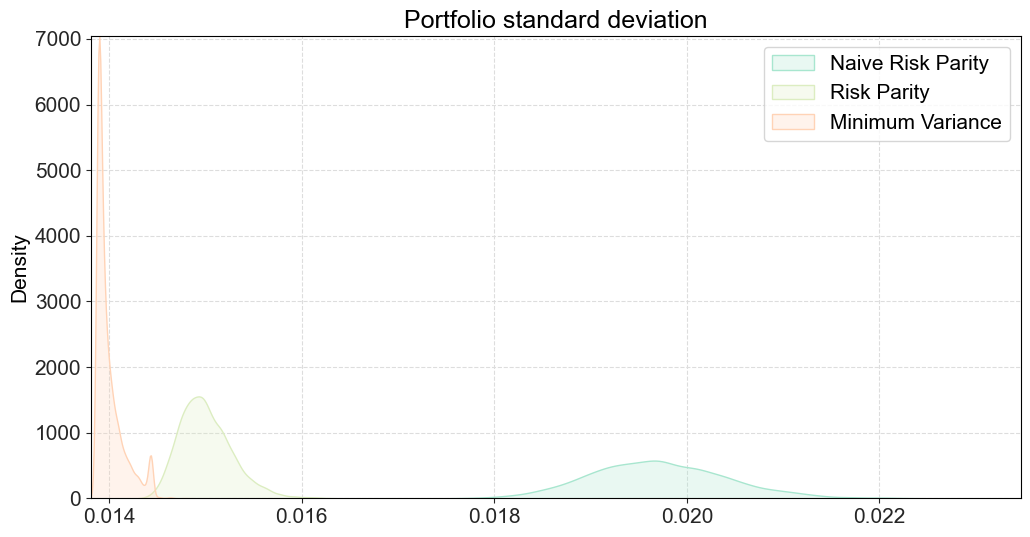

In [310]:
"""
Evaluate portfolio std.
"""
rp_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, rp_ports, (cov_mat))
naive_rp_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, naive_rp_ports, (cov_mat))
min_var_port_std = np.apply_along_axis(rm.calculate_portfolio_std, 1, min_var_ports, (cov_mat))


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_std, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_std, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_std, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio standard deviation")
ax.legend();

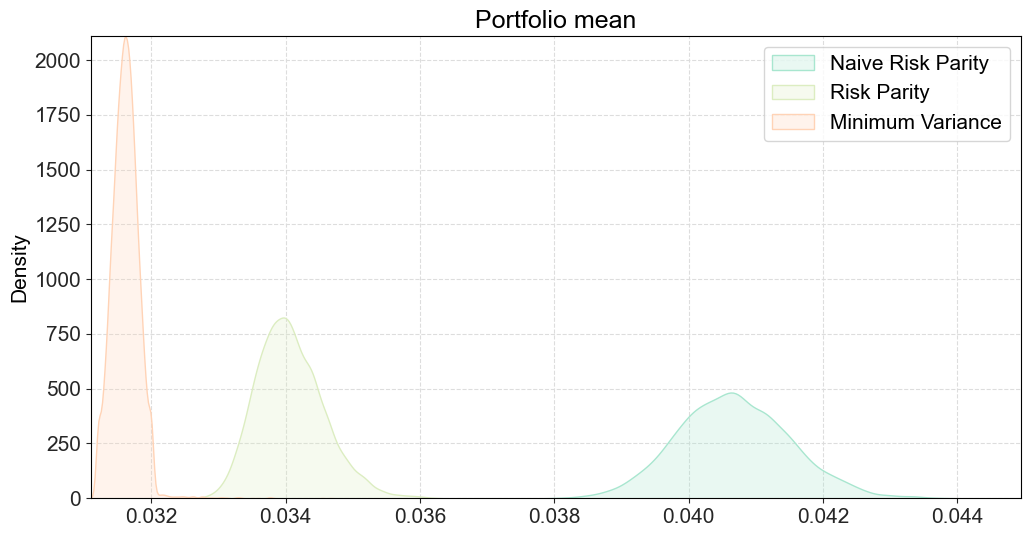

In [311]:
"""
Evaluate portfolio mean
"""
rp_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, rp_ports, (mu))
naive_rp_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, naive_rp_ports, (mu))
min_var_port_mu = np.apply_along_axis(rm.calculate_portfolio_mean, 1, min_var_ports, (mu))


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_mu, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_mu, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_mu, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio mean")
ax.legend();

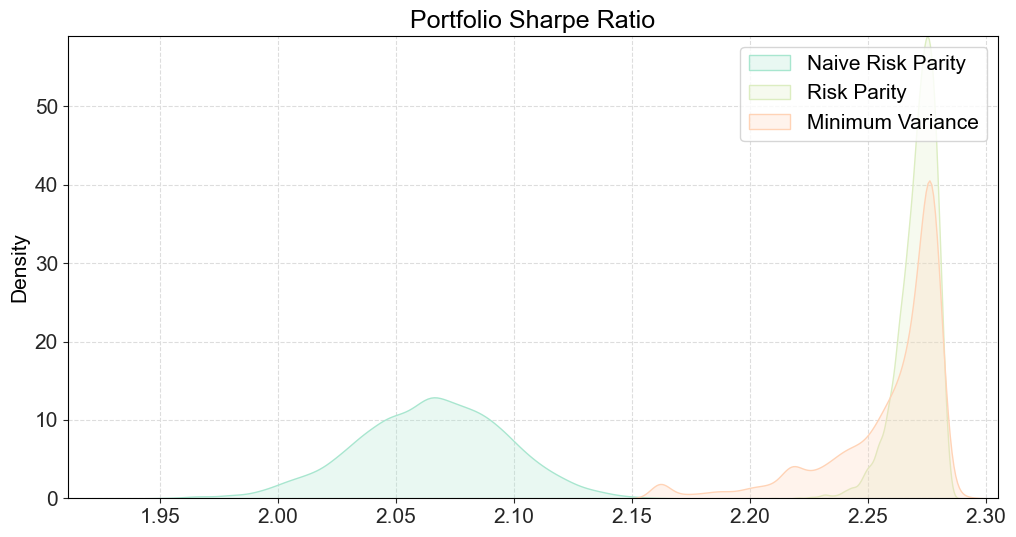

In [312]:
"""
Evaluate Sharp - zero risk free
"""
rp_port_sr = rp_port_mu / rp_port_std
naive_rp_port_sr = naive_rp_port_mu / naive_rp_port_std
min_var_port_sr = min_var_port_mu / min_var_port_std


fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(rp_port_sr, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(naive_rp_port_sr, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(min_var_port_sr, fill=True, ax=ax, label="Minimum Variance")

ax.set_title("Portfolio Sharpe Ratio")
ax.legend();

## Most Diversified Portfolio 

Another approach is to focus directly on diversification. [Choueifaty and Caignard (2008), "Toward Maximum Diversification"](https://www.tobam.fr/wp-content/uploads/2014/12/TOBAM-JoPM-Maximum-Div-2008.pdf) defines the diversification ratio

$$
\text{CC}(\mathbf{w}, \boldsymbol{\Sigma}) = \frac{\mathbf{w}^\top \mathbf{v}}{ \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma}\mathbf{w}}} = \frac{\sum_{i=1}^N w_i \sigma_i}{\sqrt{ \mathbf{w}^\top \boldsymbol{\Sigma}\mathbf{w}}}
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix and $\mathbf{v}$ is the vector of volatilities. The maximum diversification portfolio can be obtained as 

\begin{align*}
	\max_{\mathbf{w}}  \quad & \text{CC}(\mathbf{w}, \boldsymbol{\Sigma}) \\
	\textrm{s.t.} \quad & \mathbf{w}^\top \mathbf{1} = 1 \\
	 & w_i \geq 0, \; i=1,...,N
\end{align*}

__Example: Implementing the most diversified portfolio__

In [313]:
def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    """
    Calculates the diversification ratio of Chouefaty and Coignard (2008)

    .. math::

        \\begin{equation}
            \\text{GLR}(w, \\Sigma) = \\frac{\\sum_{i=1}^N w_i \\sigma_i}{\\sqrt{w^{\\top} \\Sigma w}}
        \\end{equation}

    Parameters
    ----------
    weights:
        Portfolio weights.
    cov_mat:
        Covariance matrix.
        
    Returns
    -------
    float
        Diversification ratio.
    """

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [314]:
"""
Define relevant quantities
"""
corr = np.array([[1.0, 0.9, 0.7],
                 [0.9, 1.0, 0.4],
                 [0.7, 0.4, 1.0]])


vols = np.array([0.2, 0.15, 0.1])

rf = 0.0 # assume that the risk free rate is zero 
mu = vols * 0.2 # constant Sharpe ratio

# transform to covariance matrix using previously defined function (imported at the top of the notebook)
cov_mat = corr_to_cov_matrix(corr, vols)

# number of assets
num_assets = len(mu)

In [315]:
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:
    
    # define intial values
    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)
    
    # define sum to one constraint
    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # perform optimization
    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat) * 100 * 100, init_weights,
                            constraints=[eq_constraint,], bounds=[(0, 1)]*n)
    
    return res.x

In [316]:
df_port_w['$w_{cc}$'] = calculate_most_diversified_portfolio(cov_mat)
df_port_w

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$,$w_{cc}$
Asset 1,4.782386e-22,0.202225,0.230769,0.0
Asset 2,1.951220e-01,0.307039,0.307692,0.4
Asset 3,8.048780e-01,0.490736,0.461538,0.6


In [317]:
"""
Correlation between assets and CC-portfolio
"""

w_cc = df_port_w['$w_{cc}$'].values
idx = 2
pick_vec = np.zeros(num_assets)
pick_vec[idx] = 1.0

w_cc @ cov_mat @ pick_vec / (rm.calculate_portfolio_std(w_cc, cov_mat) * vols[idx])

0.8366599353592609

## Norm and diversification constraints

[Victor DeMiguel, Lorenzo Garlappi, Francisco J. Nogales and Raman Uppal (2009), "A Generalized Approach to Portfolio Optimization: Improving Performance by Constraining Portfolio Norms"](https://www.jstor.org/stable/40539189) discuss different norm constraints in the context of the minimum-variance portfolio. One example is the use of a 2-norm constraint: 

\begin{align*}
	\min_{\mathbf{w}}  \quad & \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}\\
	\textrm{s.t.} \quad & \mathbf{w}^\top \mathbf{1} = 1 \\
	 & w_i \geq 0, \; i=1,...,N \\
     & \Vert \mathbf{w} \Vert_2 \leq \delta
\end{align*}

Note that 

$$
\Vert \mathbf{w} \Vert_2 = \sum_{i=1}^N w_i^2 
$$

Thus, if $\delta = 1/N$ then we will end up with the naive, equally weighted portfolio. We can therefore think of this constraints as a restriction of how far we can deviate frim the $1/N$ portfolio. 

In [318]:
def calculate_minimum_variance_norm(cov_mat: np.ndarray, delta: float) -> np.ndarray: 
    
    num_assets = cov_mat.shape[0]
    
    # optimization variable
    w = cp.Variable(num_assets)

    # define constraints 
    constraints = [cp.sum(w)==1.0, w>=0, cp.quad_form(w, np.eye(num_assets)) <= delta]

    # define problem 
    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)
    
    # solve problem 
    try:  
        prob.solve()
    except: 
        prob.solve(solver="SCS")
    
    return w.value

In [319]:
df_port_w['$w_{min-var, L2}$'] = calculate_minimum_variance_norm(cov_mat, delta=0.4)
df_port_w

,$w_{min-var}$,$w_{rb}$,$w_{inv-vol}$,$w_{cc}$,"$w_{min-var, L2}$"
Asset 1,4.782386e-22,0.202225,0.230769,0.0,0.142707
Asset 2,1.951220e-01,0.307039,0.307692,0.4,0.350676
Asset 3,8.048780e-01,0.490736,0.461538,0.6,0.506617


## Application: Industry Portfolios 

We consider an asset allocation exercise on a industry portfolio data set. 

We seek to, for each time step, 

* Calculate the covariance matrix
* Calculate optimal portfolios using some of the present "heuristic" methods

Based on the obtained portfolios, we evaluate the performance for the strategies. 

In [320]:
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets


"""
Obtain Fama-French Industry portfolios since 1970
"""

ff_dict = FamaFrenchReader('49_Industry_Portfolios', start='1970-01-01').read()

ff_daily_dict = FamaFrenchReader('49_Industry_Portfolios_Daily', start='2000-01-01').read()  # , end='2020-01-01'

In [321]:
ff_dict['DESCR']

'49 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202309 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (645 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Monthly (645 rows x 49 cols)\n  2 : Average Value Weighted Returns -- Annual (53 rows x 49 cols)\n  3 : Average Equal Weighted Returns -- Annual (53 rows x 49 cols)\n  4 : Number of Firms in Portfolios (645 rows x 49 cols)\n  5 : Average Firm Size (645 rows x 49 cols)\n  6 : Sum of BE / Sum of ME (54 rows x 49 cols)\n  7 : Value-Weighted Average of BE/ME (54 rows x 49 cols)'

In [322]:
ff_daily_dict['DESCR']

'49 Industry Portfolios Daily\n----------------------------\n\nThis file was created by CMPT_IND_RETS_DAILY using the 202309 CRSP database. It contains value- and equal-weighted returns for 49 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Daily (5974 rows x 49 cols)\n  1 : Average Equal Weighted Returns -- Daily (5974 rows x 49 cols)'

In [323]:
"""
Get Market Cap weights for each month
"""

# market capitialization for each sector 
df_mc = ff_dict[4] * ff_dict[5]

# total market cap. for each month
total_mc =  df_mc.sum(axis=1)

# relative weights 
df_weights = df_mc.divide(total_mc, axis=0 ) 

# show weights
df_weights.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1970-01,0.000534,0.028071,0.011377,0.005430,0.006714,0.006979,0.003919,0.006869,0.088870,0.006328,...,0.019426,0.019509,0.004468,0.052637,0.007329,0.017363,0.010701,0.002363,0.017277,0.000169
1970-02,0.000581,0.029514,0.011915,0.005794,0.006751,0.006950,0.004003,0.006588,0.089508,0.006507,...,0.019228,0.019468,0.004458,0.053663,0.006986,0.017358,0.010520,0.002268,0.016678,0.000173
1970-03,0.000607,0.029630,0.011759,0.005872,0.006370,0.006996,0.004099,0.006282,0.085180,0.006345,...,0.019359,0.019363,0.004313,0.053825,0.007000,0.019053,0.011010,0.002187,0.017249,0.000156
1970-04,0.000529,0.029561,0.011650,0.005852,0.006487,0.006820,0.004014,0.006134,0.084706,0.006328,...,0.019009,0.018785,0.004102,0.053569,0.006496,0.018765,0.011033,0.002176,0.017211,0.000157
1970-05,0.000483,0.029501,0.011883,0.005916,0.007033,0.006099,0.003518,0.005821,0.086985,0.006055,...,0.018927,0.018481,0.003650,0.053752,0.005920,0.018644,0.010412,0.001976,0.016788,0.000124


In [324]:
"""
Set color map for better visualization 
"""
cmap = plt.get_cmap('jet')
ind_colors = cmap(np.linspace(0, 1, 49))

### Plotting market cap weights over time

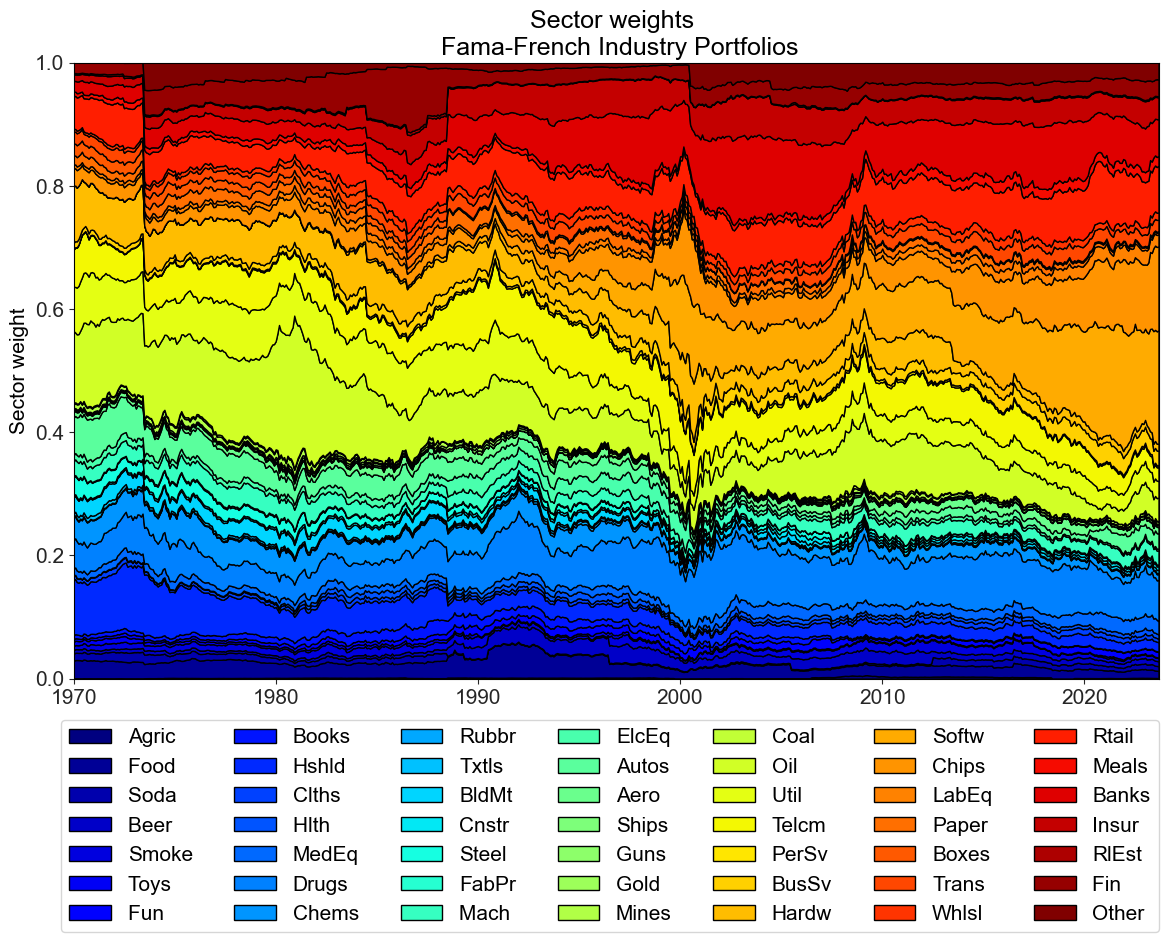

In [325]:
"""
Portfolio weights over time
"""

fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(df_weights.index.to_timestamp(),
              df_weights.values.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weight')
ax.set_title("Sector weights \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

A simplistic or naive view of portfolio diversification is to look at the number of constituents in the portfolios or the portfolio weights. One possibility is to use the norm of the portfolio weight vector, $\mathbf{w}$, to determine the Effective Number of Constituents (ENC)  (valid for any $\alpha > 0$ if weights are all positive)

\begin{equation*}
\text{ENC}_{\alpha} (\mathbf{w}) = \Vert \mathbf{w} \Vert_{\alpha}^{\frac{\alpha}{1 - \alpha}} = \left(\sum_{i=1}^N w_i^\alpha \right)^{\frac{1}{1-\alpha}}, \; \; \alpha > 0, \; \alpha \neq 1
\end{equation*}

where $N$ denote the number of assets. If $\alpha = 2$, the diversification measure is equal to the inverse of the \href{https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index}{Herfindahl index}

\begin{equation*}
\text{ENC}_{2} (\mathbf{w}) = \frac{1}{\sum_{i=1}^N w_i^2}
\end{equation*}

In the limiting case when $\alpha \to 1$, we obtain the exponential of the entropy of the distribution of the portfolio weight vector

\begin{equation*}
\text{ENC}_{1} = \exp \left( - \sum_{i=1}^N w_i \ln w_i\right)
\end{equation*}

__Note:__ The function to calculate ENC is defined in `codelib.portfolio_optimization.diversification`.

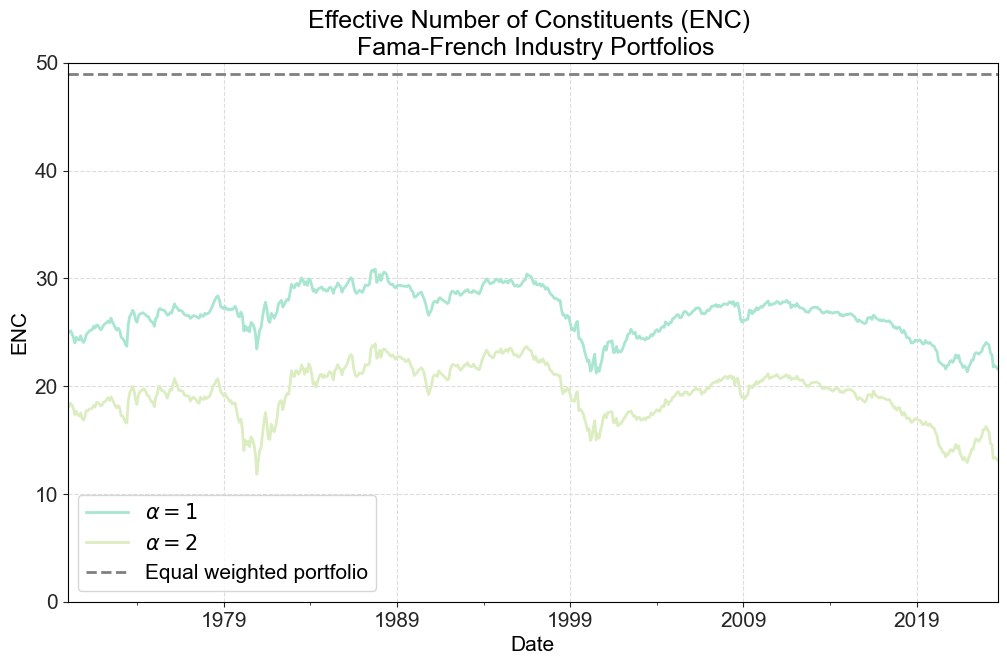

In [326]:
"""
Calculate Effective Number of Constituents (ENC) based on market capitialization
"""

df_enc1 = df_weights.apply(dm.calculate_enc, axis=1)
df_enc2 = df_weights.apply(dm.calculate_enc, axis=1, args=(2,))

fig, ax = plt.subplots(figsize=(12, 7))

df_enc1.plot(ax=ax, label="$\\alpha=1$")
df_enc2.plot(ax=ax, label="$\\alpha=2$")

ax.axhline(49, color='gray', linestyle='--', label="Equal weighted portfolio")
ax.set_ylim([0.0, 50.0])

ax.set_ylabel("ENC")
ax.set_title("Effective Number of Constituents (ENC) \n Fama-French Industry Portfolios")

ax.legend();

### Finding "optimal" portfolios

We choose an estimation horizon of one week since it provides a good trade off between the number of independent observations and the homogeneity of the data. 

Furthermore, we choose to use Exponential Weighted Moving Average (EWMA) filter to estimate the covariance matrix. We apply a window of 5 years of weekly observations and a half-life of 104 weeks (2 years).  

I use the "Average Value weighted Returns", but you can also choose to use the "Average Equal Weighted Returns". 

To perform the analysis, we can use `calculate_exponential_decay_probabilities` to calculate exponential probabilities. Given the probabilities, we can use `calculate_cov_mat` to calculate the covariance matrix. To calculate the risk contributions, we can use `calculate_risk_contributions_std`. All functions are imported in the begining of the notebook. 

In [327]:
"""
Calculate daily total return index
"""

ff_daily_ret = ff_daily_dict[0] / 100 # daily ret trans
ff_daily_prices = (1+ff_daily_ret).cumprod()

"""
Calculate weekly prices and return index
"""

ff_weekly_prices = ff_daily_prices.resample('W-WED').last()  # W-WED
ff_weekly_ret = ff_weekly_prices / ff_weekly_prices.shift(1) - 1
ff_weekly_ret.iloc[0, :] = ff_weekly_prices.iloc[0, :] - 1

In [328]:
"""
Initialize values
"""

# number of periods
num_periods = len(ff_weekly_ret)

# number of factors
num_assets = ff_weekly_ret.shape[1]

# window size 
window_size =  52 * 5 # 5 years of weekly observations 

# effective number of periods
eff_num_periods = num_periods - window_size

# half-life
half_life = 104

# time points
time_points = np.arange(1, window_size + 1)

# exponential probabilities 
exp_probs = calculate_exponential_decay_probabilities(window_size, time_points, half_life)

# equally weighted portfolio
eq_weigts = np.repeat(1.0 / num_assets, num_assets)

In [329]:
"""
Calculate optimal portfolios
"""

most_div_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_port_weights = np.zeros((eff_num_periods, num_assets))
min_var_norm_port_weights = np.zeros((eff_num_periods, num_assets))
rp_port_weights = np.zeros((eff_num_periods, num_assets))

cc_ratios = np.zeros(eff_num_periods)
most_div_port_cc = np.zeros(eff_num_periods)
min_var_port_cc = np.zeros(eff_num_periods)
min_var_norm_port_cc = np.zeros(eff_num_periods)
rp_port_cc = np.zeros(eff_num_periods)

"""
Perform calculations
"""

for t in range(eff_num_periods):
    
    # covariance matrix
    cov_mat = moments.calculate_cov_mat(ff_weekly_ret.iloc[t: window_size + t, :].values, probs=exp_probs)
    
    # equally weighted
    cc_ratios[t] = calculate_cc_ratio(eq_weigts, cov_mat)
    
    # most diversified
    most_div_port_weights[t, :] = calculate_most_diversified_portfolio(cov_mat)
    most_div_port_cc[t] = calculate_cc_ratio(most_div_port_weights[t, :], cov_mat)
    
    # mnimum variance
    min_var_port_weights[t, :] = calculate_minimum_variance(cov_mat)
    min_var_port_cc[t] = calculate_cc_ratio(min_var_port_weights[t, :], cov_mat)
    
    # mnimum variance norm-constrained
    min_var_norm_port_weights[t, :] = calculate_minimum_variance_norm(cov_mat, delta=0.05)
    min_var_norm_port_cc[t] = calculate_cc_ratio(min_var_norm_port_weights[t, :], cov_mat)
    
    # risk parity
    rp_port_weights[t, :] = calculate_risk_parity(cov_mat)
    rp_port_cc[t] = calculate_cc_ratio(rp_port_weights[t, :], cov_mat)

C:\Users\johan\anaconda3\envs\fin_econ_2023\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Plotting allocations

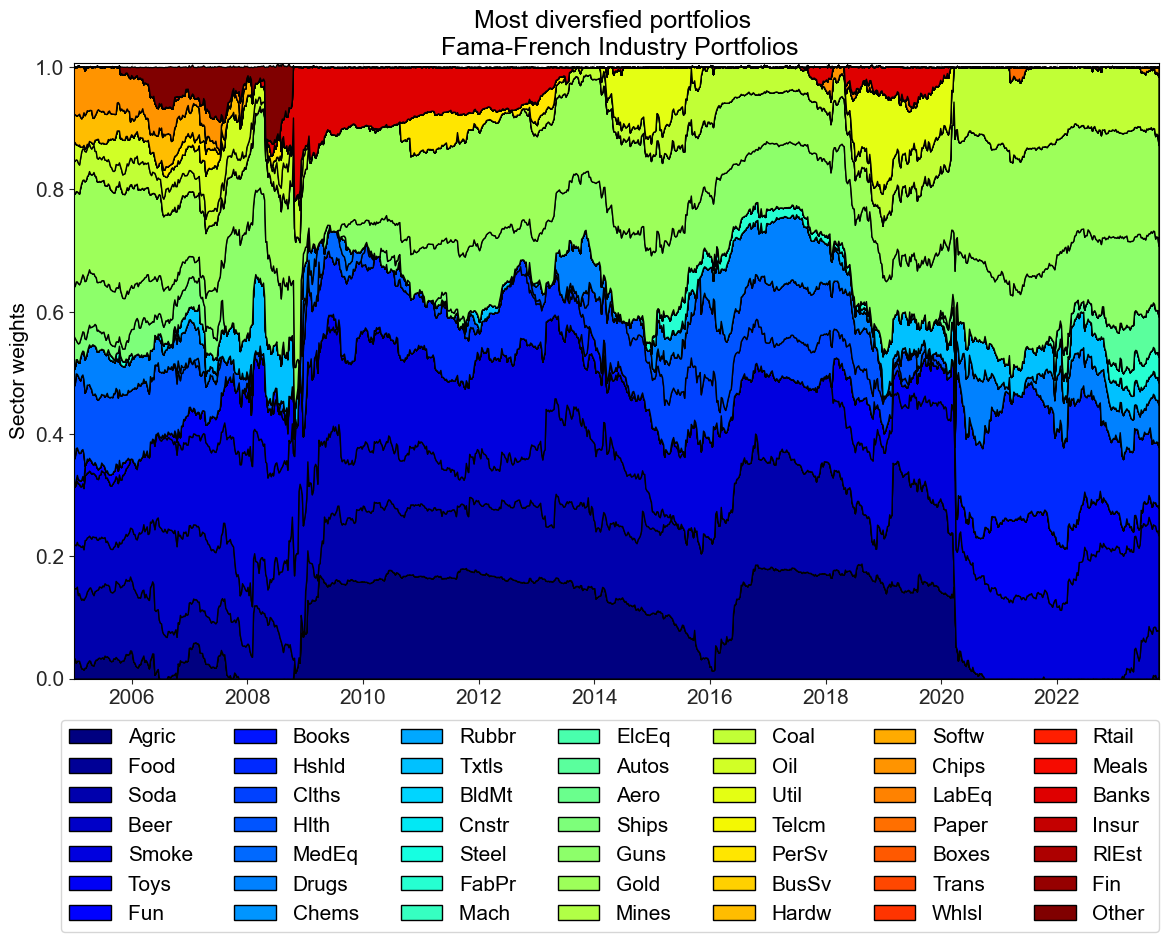

In [330]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              most_div_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Most diversfied portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

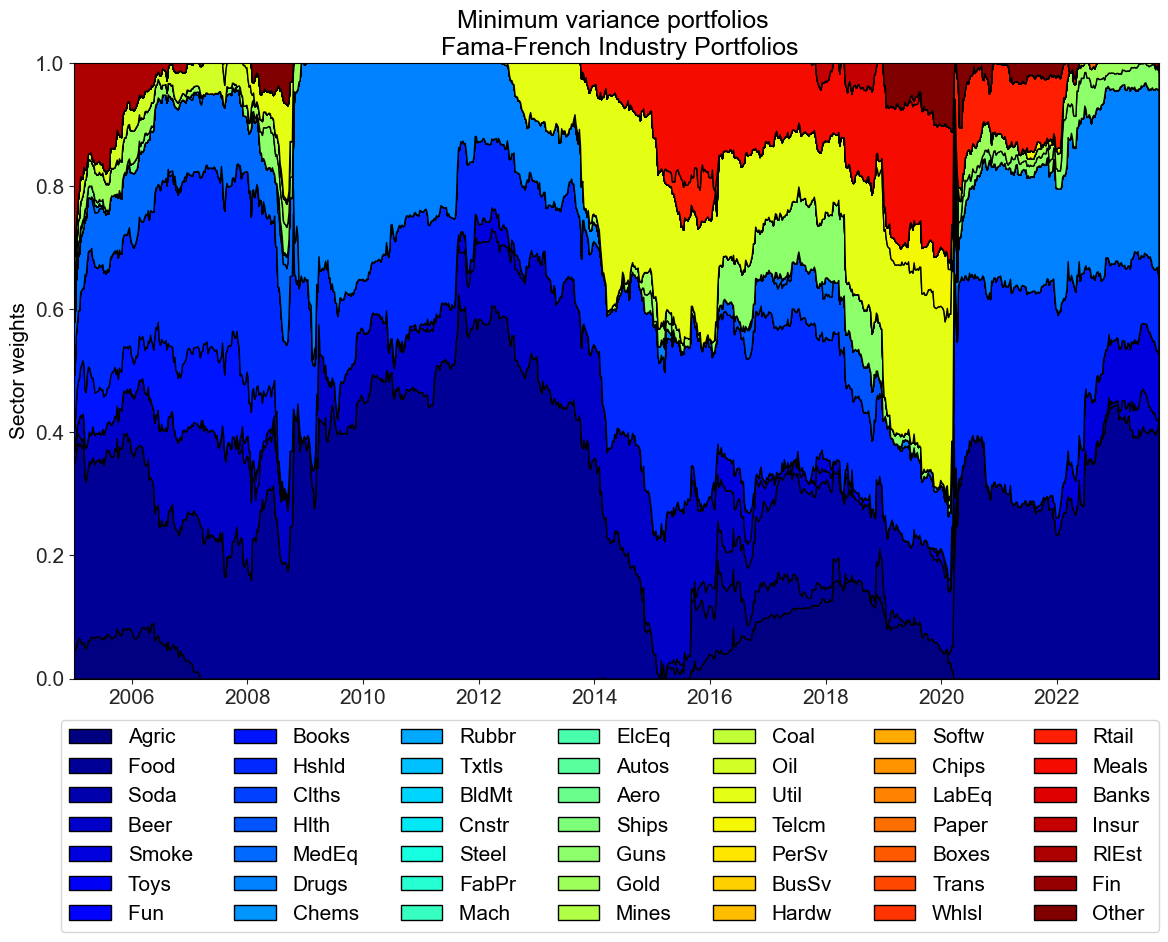

In [331]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              min_var_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

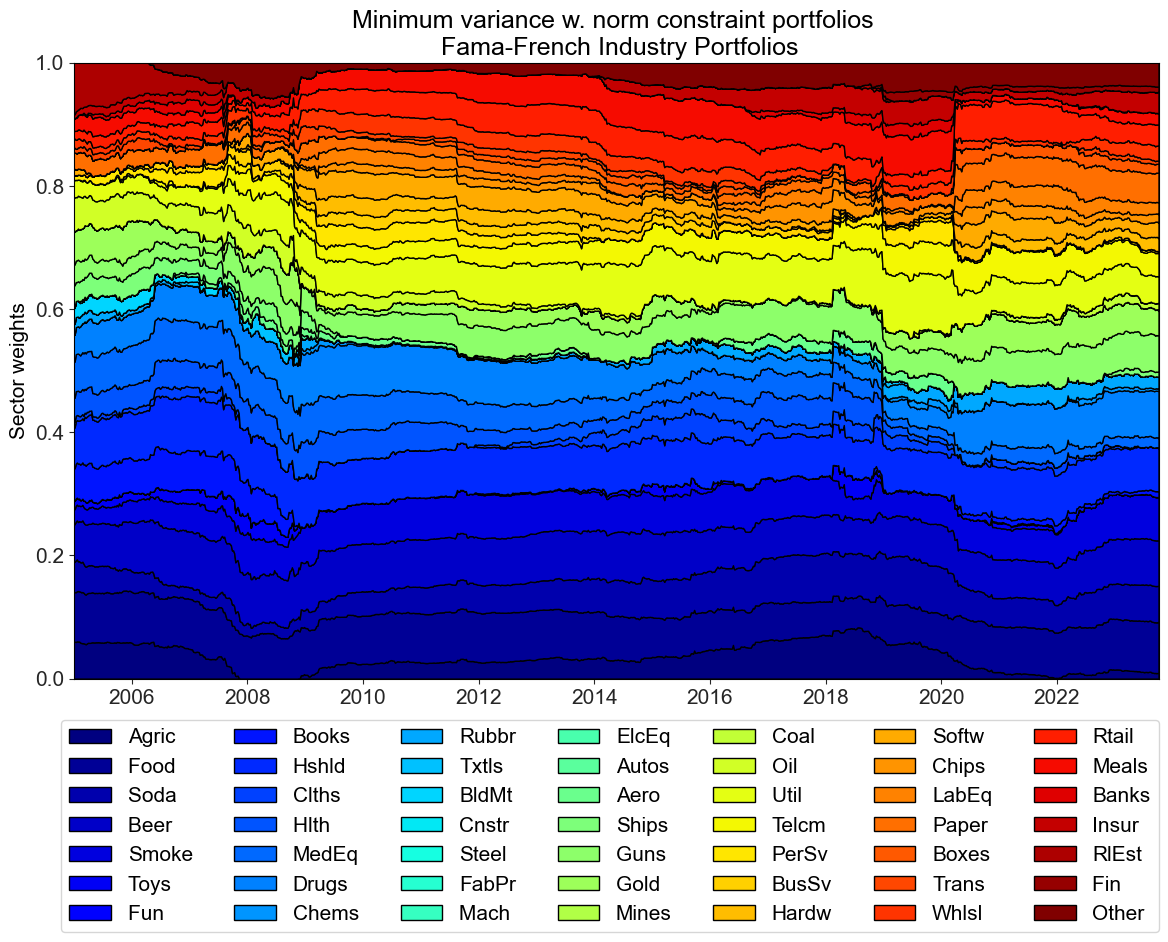

In [332]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              min_var_norm_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Minimum variance w. norm constraint portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

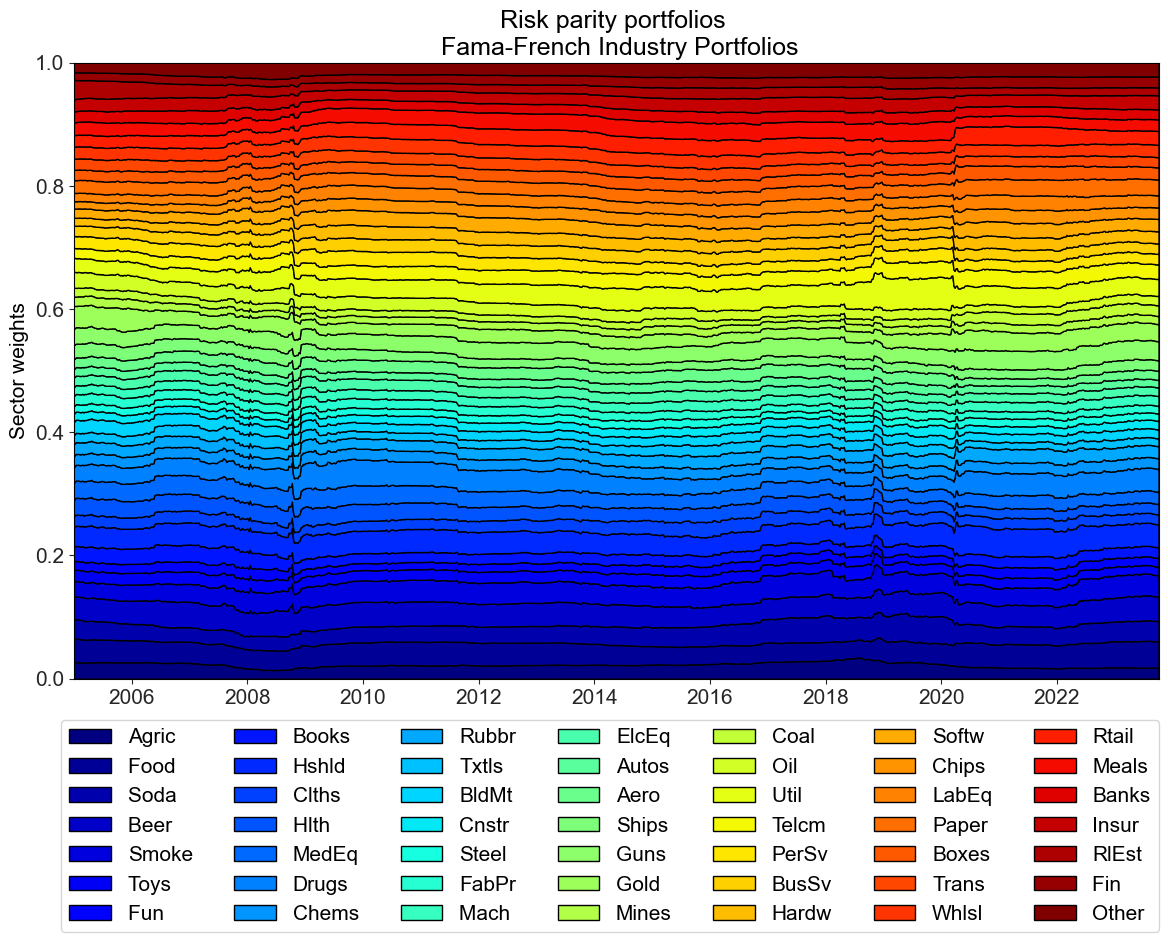

In [333]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.stackplot(ff_weekly_ret.index[window_size:],
              rp_port_weights.T,
              edgecolor="black",
              labels=df_weights.columns,
              colors=ind_colors);

ax.set_ylabel('Sector weights')
ax.set_title("Risk parity portfolios \n Fama-French Industry Portfolios");
ax.legend(ncol=7, bbox_to_anchor=(1.01, -0.05));

### Diversification ratios

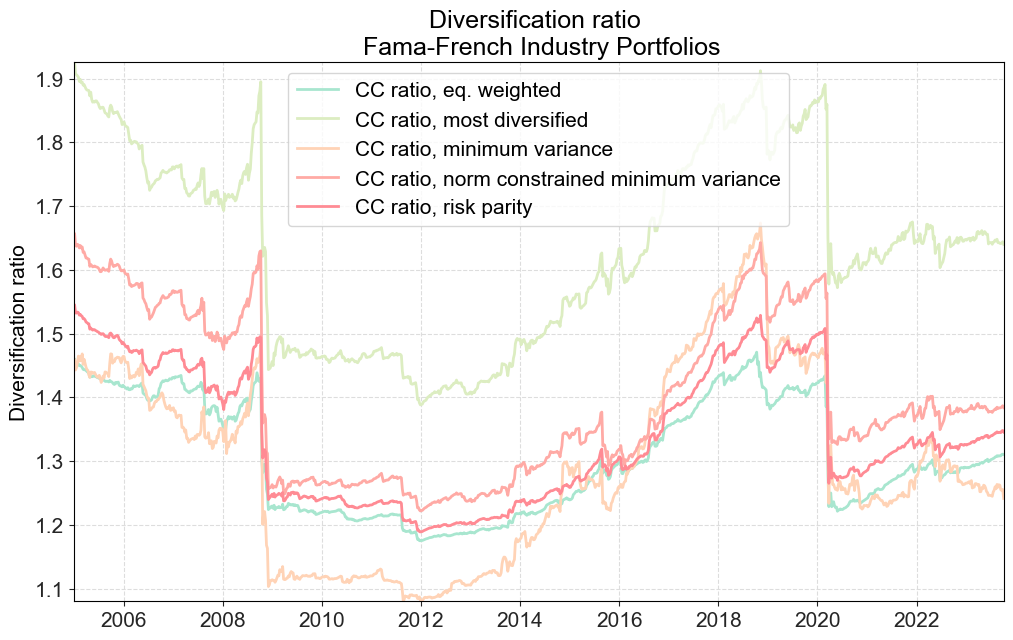

In [334]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(ff_weekly_ret.index[window_size:], cc_ratios, label="CC ratio, eq. weighted")
ax.plot(ff_weekly_ret.index[window_size:], most_div_port_cc, label="CC ratio, most diversified")
ax.plot(ff_weekly_ret.index[window_size:], min_var_port_cc, label="CC ratio, minimum variance")
ax.plot(ff_weekly_ret.index[window_size:], min_var_norm_port_cc, label="CC ratio, norm constrained minimum variance")
ax.plot(ff_weekly_ret.index[window_size:], rp_port_cc, label="CC ratio, risk parity")
ax.set_ylabel("Diversification ratio")
ax.set_title("Diversification ratio \n Fama-French Industry Portfolios");
ax.legend();

### Evaluating strategies

In [335]:
# store in data-frames
df_most_div_port_weights = pd.DataFrame(data=most_div_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

df_min_var_port_weights = pd.DataFrame(data=min_var_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

df_min_var_norm_port_weights = pd.DataFrame(data=min_var_norm_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

df_rp_port_weights = pd.DataFrame(data=rp_port_weights,
                                        index=ff_weekly_ret[window_size:].index,
                                        columns=ff_weekly_ret.columns)

In [336]:
df_port_ret = pd.DataFrame(index=ff_weekly_ret.index[window_size:])

# weekly return
df_port_ret['min-var'] = (ff_weekly_ret[window_size:] * df_min_var_port_weights).sum(axis=1)
df_port_ret['most-div'] = (ff_weekly_ret[window_size:] * df_most_div_port_weights).sum(axis=1)
df_port_ret['min-var-norm'] = (ff_weekly_ret[window_size:] * df_min_var_norm_port_weights).sum(axis=1)
df_port_ret['rp'] = (ff_weekly_ret[window_size:] * df_rp_port_weights).sum(axis=1)
df_port_ret['eq-weight'] = (ff_weekly_ret[window_size:] @ eq_weigts)

# total return index
df_port_tri = (1 + df_port_ret).cumprod(axis=0)

In [337]:
(1 + df_port_ret).prod(axis=0)

min-var         4.358678
most-div        4.521796
min-var-norm    5.181674
rp              5.409556
eq-weight       5.488139
dtype: float64

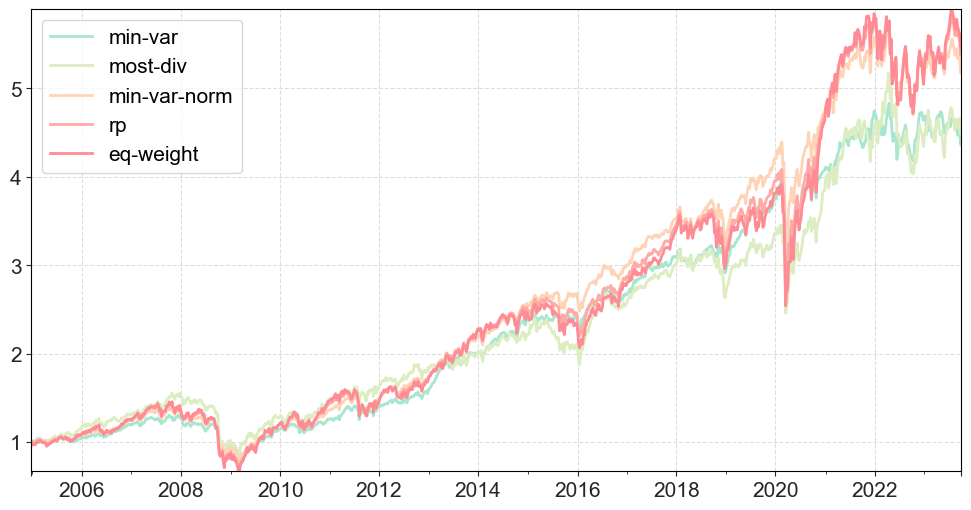

In [338]:
df_port_tri.plot(xlabel="", figsize=(12, 6));

In [339]:
mean_return = df_port_ret.mean(axis=0)
mean_return

min-var         0.001651
most-div        0.001816
min-var-norm    0.001867
rp              0.002015
eq-weight       0.002092
dtype: float64

In [340]:
std_return = df_port_ret.std(axis=0)
std_return

min-var         0.017105
most-div        0.023357
min-var-norm    0.019205
rp              0.023908
eq-weight       0.026371
dtype: float64

The information ratio is given by 

\begin{equation*}
\text{IR} = \frac{\text{E}[R_p]}{\sigma_P}
\end{equation*}

where $R_p$ is the portfolio return and $\sigma_P$ is the portfolio standard deviation (need to be replaced with estimates). 

In [341]:
ir_ratio = mean_return / std_return
ir_ratio

min-var         0.096549
most-div        0.077737
min-var-norm    0.097216
rp              0.084265
eq-weight       0.079344
dtype: float64

We can define turn-over as 

\begin{equation*}
\text{Turn-Over} = \frac{1}{T_{OOS} - 1}\sum_{t=1}^{T_{OOS} - 1} \sum_{i=1}^N \vert \tilde{w}_{i, t+1} - w_{i, t+1} \vert
\end{equation*}

where $T_{OOS} - 1$ is the number of re-balancing dates and 

\begin{equation*}
\tilde{w}_{i, t+1} = \frac{w_{i, t}(1 + R_{i, t+1})}{1+R_{p, t+1}}
\end{equation*}

is the portfolio weight of asset $i$ immediately before re-balancing.

In [342]:
def calculate_turn_over(df_port_weights, df_asset_return): 
    
    df_port_ret = (df_asset_return * df_port_weights).sum(axis=1)
    df_adj_weights = ((1 + df_asset_return) * df_port_weights).divide(1 + df_port_ret.values, axis=0)
    df_w_diff = (df_adj_weights.shift(1) - df_adj_weights).dropna()
    
    return np.mean(np.linalg.norm(df_w_diff, axis=1, ord=1)) * 100

In [343]:
calculate_turn_over(df_min_var_port_weights, ff_weekly_ret[window_size:])

4.727925613220719

In [344]:
df_turn_over = pd.DataFrame(data=[], index=["Turn-over"])
df_turn_over.loc[:, 'eq-weight'] = calculate_turn_over(eq_weigts, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'min-var'] = calculate_turn_over(df_min_var_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:,'most-div'] = calculate_turn_over(df_most_div_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'min-var-norm'] = calculate_turn_over(df_min_var_norm_port_weights, ff_weekly_ret[window_size:])
df_turn_over.loc[:, 'rp'] = calculate_turn_over(df_rp_port_weights, ff_weekly_ret[window_size:])

df_turn_over

,eq-weight,min-var,most-div,min-var-norm,rp
Turn-over,2.239825,4.727926,6.053281,2.773603,2.200958


## Literature 

[Bruder and Roncalli (2012), "Managing Risk Exposures using
the Risk Budgeting Approach"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2009778)

[Choueifaty and Caignard (2008), "Toward Maximum Diversification"](https://www.tobam.fr/wp-content/uploads/2014/12/TOBAM-JoPM-Maximum-Div-2008.pdf)

[Victor DeMiguel, Lorenzo Garlappi, Francisco J. Nogales and Raman Uppal (2009), "A Generalized Approach to Portfolio Optimization: Improving Performance by Constraining Portfolio Norms"](https://www.jstor.org/stable/40539189)